In [47]:
import numpy as np
import numpy.lib.stride_tricks as slide

ERROR = 0.05
OPTIMIZE_INT = True
ALLOW_THREADS = 1

CLASSES = [
    'cyl',
    'inter',
    'let',
    'mod',
    'para',
    'super',
    'svar'
]

def rgbToMean(input, output):
    np.copyto(output, np.sum(input, axis=2) // 3, casting='unsafe')

def rgbToLightness(input, output):
    a = np.max(input, axis=2)
    b = np.min(input, axis=2)
    return (a + b) // 2
    
lumWeights = np.array([21, 72, 7])
def rgbToLuminosity(input, output):
    np.copyto(output, np.sum((lumWeights * input) // 100, axis=2), casting='unsafe')
    
def rgbToIntensity(input, output, weights, divisor = 1):
    weights = np.array(weights)
    if weights.shape != (0,) and len(weights.shape) == 1 and weights.shape[0] == 3:
        raise ValueError('Weights must be of shape [3]')
        
    np.copyto(output, np.sum((weights * input), axis=2) // 1, casting='unsafe')
    
def intensityToRgb(input, output):
    np.copyto(output, np.repeat(input.reshape(input.shape + (1,)), 3, axis=2), casting='unsafe')

def saltAndPepper(input, output, threshold):
    noise = np.random.rand(*input.shape)
    white = np.ones(input.shape) * 255
    black = np.zeros(input.shape)
    halfThreshold = threshold/2.0
    np.copyto(output, np.choose((noise < threshold) * 1 + (noise < halfThreshold) * 1, [input, white, black]), casting='unsafe')
    
def gaussianNoise(input, output, stdDeviation = 50):
    noise = np.random.normal(0, stdDeviation, input.shape)
    mixed = np.clip(np.random.normal(0,stdDeviation,input.shape) + input, 0, 255, dtype="uint8", casting="unsafe")
    np.copyto(output, mixed, casting='unsafe')
    
def noise(output):
    noise = np.random.rand(*output.shape)
    np.copyto(output, noise*255, casting='unsafe')
    
def histogram(input, output):
    step = 255 / len(output)
    output.fill(0)
    # Implementation that doesn't use specific method from library as demonstration of knowledge:
    # indices = np.array([intensity // step for y in input for intensity in y], dtype='uint')
    # for i in indices:
    #    histo[i] = histo[i] + 1
    gram, _ = np.histogram(input, bins=output.shape[0])
    np.copyto(output, gram, casting='unsafe')
    
def quantize(input, output, ts):
    indices = np.digitize(input, ts, right=True) - 1
    levels = np.append(ts, 255)
    np.copyto(output, [[(levels[i + 1] - levels[i]) / 2 + levels[i]  for i in j] for j in indices], casting='unsafe')
        
def quantizeUniform(input, output, delta):
    quantize(input, output, np.arange(0,255,delta))
    #np.copyto(output, [[delta * math.floor(val / delta) + delta / 2 for val in y] for y in input], casting='unsafe')
    
    

def slideKernel(input, kernel, mode='edge'):
    if(kernel.shape[0] % 2 == 0 or kernel.shape[1] % 2 == 0):
        raise ValueError('Only odd dimension kernels are supposed')
    padded = np.pad(input, (kernel.shape[0] // 2, kernel.shape[1] // 2), mode=mode)
    return slide.sliding_window_view(padded, kernel.shape) * kernel
    
def smoothFilter(input, output, kernel, mode='edge'):
    if abs(np.sum(kernel) - 1) > ERROR:
       raise ValueError('Smooth kernel must sum to 1')
    slid = slideKernel(input, kernel, mode)
    result = np.sum(np.sum(slid, axis=3), axis=2)
    np.copyto(output, np.clip(result, 0, 255), casting='unsafe')
    
def diffFilter(input, output, kernel, mode='edge'):
    if abs(np.sum(kernel)) > ERROR:
       raise ValueError('Difference kernel must sum to 0')
    slid = slideKernel(input, kernel, mode)
    result = np.sum(np.sum(slid, axis=3), axis=2) + 128
    np.copyto(output, np.clip(result, 0, 255), casting='unsafe')
    
def linearFilter(input, output, kernel, mode='edge'):
    if np.any(kernel, where=kernel):
        diffFilter(input, output, kernel, mode)
    else:
        smoothFilter(input, output, kernel, mode)

def medianFilter(input, output, kernel, mode='edge'):
    slid = slideKernel(input, kernel, mode)
    np.copyto(output, [[np.median(x) for x in y] for y in slid], casting='unsafe')
    
    
def averageOfHistrograms(listOfHistograms):
    rotated = np.swapaxes(listOfHistograms, 0, 1)
    return np.average(rotated, axis=1)
    


In [48]:
import numpy as np
import numpy.lib.stride_tricks as slide
import imageio as iio
from IPython.display import Image
import matplotlib.pylab as plt
import matplotlib.pyplot as plot
import io
import math

ALLOW_THREADS = 1


img = iio.imread('./images/cyl01.BMP')

buffer = np.zeros(img.shape[0:2], dtype=img.dtype)
buffer2 = np.zeros(img.shape[0:2], dtype=img.dtype)
buffer3 = np.zeros(img.shape[0:2], dtype=img.dtype)
buckets = 10
step = 255 / buckets
histo = np.zeros(buckets, dtype='uint32')





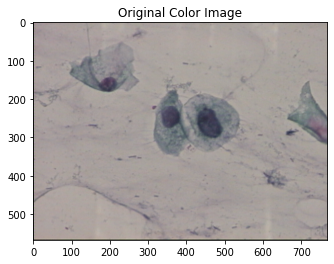

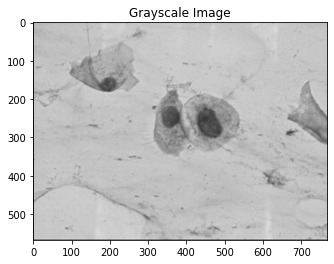

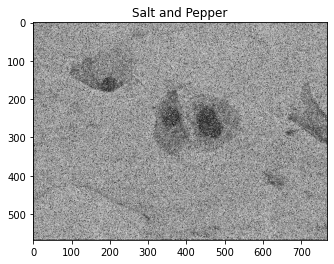

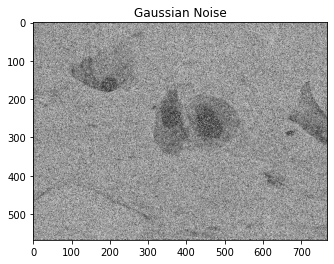

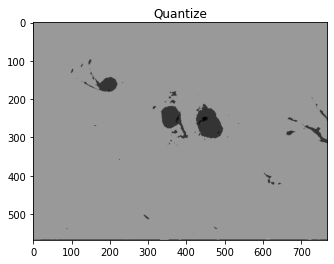

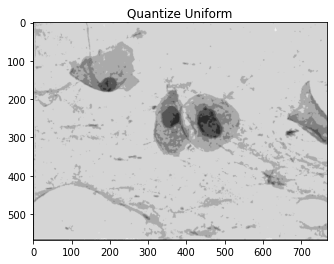

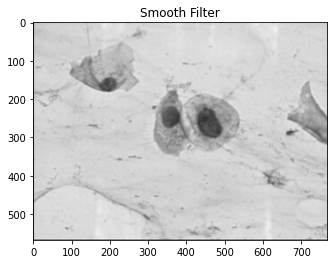

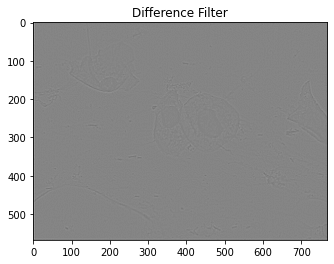

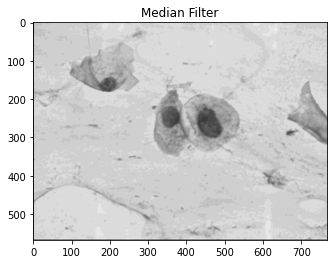

In [101]:
from time import perf_counter
import glob

def sAndP(input, output):
    saltAndPepper(input, output, 0.2)

def gaus(input, output):
    gaussianNoise(input, output, 50)
    
def quant(input, output):
    quantize(input, output, [20,50,100,200])

def quantUniform(input, output):
    quantizeUniform(input, output, 30)
    
def sFilter(input, output):
    smoothFilter(input, output, np.ones((3,3))/9)
    
def dFilter(input, output):
    diffFilter(input, output, 
               np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]))
    
def medFilter(input, output):
    medianFilter(input, output, np.ones((3,3))/9)
    

def doPipeline(pathGlob, prefix, extension, method, write=False):
    times = [];
    for i, filePath in enumerate(glob.glob(pathGlob)):
        if write:
            print(f'{i} {filePath}')
        img = iio.imread(filePath)
        rgbToLuminosity(img, buffer)
        
        start = perf_counter()
        method(buffer, buffer2)
        end = perf_counter()
        
        times.append(end - start)
        
        
        if write:
            iio.imwrite(f'./output/{prefix}{i}{extension}', buffer2)
    return times;


def doHistoPipeline(pathGlob, prefix, extension, write=False):
    times = [];
    results = []
    files = glob.glob(pathGlob)
    for i, filePath in enumerate(files):
        if write:
            print(f'{i} {filePath}')
        img = iio.imread(filePath)
        rgbToLuminosity(img, buffer)
        
        start = perf_counter()
        histogram(buffer, histo)
        end = perf_counter()
        
        
        times.append(end - start)
        results.append(np.copy(histo))
        
        if write:
            iio.imwrite(f'./output/{prefix}{i}{extension}', histo)
    return times, files, results;
    
def doFullStatRun(method):
    start = perf_counter()
    times = doPipeline('./images/cyl0*', 'cyl0', '.png', method)
    end = perf_counter()

    avgTime = np.mean(np.array(times, dtype="float64"))
    print(f'Full Pipeline: {end - start} seconds.  Average inner operation: {avgTime}')
    
def doFullhistoStatRun():
    start = perf_counter()
    times, files, results = doHistoPipeline('./images/0*', 'cyl0', '.png')
    end = perf_counter()

    avgTime = np.mean(np.array(times, dtype="float64"))
    
    for i, f in enumerate(files):
       print(f'{f} {results[i]}')
    #print(f'Full Pipeline: {end - start} seconds.  Average inner operation: {avgTime}')
    
    
def calcHistoAverage(clas):
    times, files, results = doHistoPipeline(f'./images/{clas}*', '', '');
    return averageOfHistrograms(results);

def doAverages():
    for c in CLASSES:
        result = calcHistoAverage(c)
        print(f'class {c}: {result}')
        
def displayComparisons(file):
    img = iio.imread(f'./images/{file}.BMP')
    rgbToLuminosity(img, buffer)
    methods = [    
        sAndP,
        gaus,
        quant,
        quantUniform,
        sFilter,
        dFilter,
        medFilter
    ]
    
    methodNames = [    
        'Salt and Pepper',
        'Gaussian Noise',
        'Quantize',
        'Quantize Uniform',
        'Smooth Filter',
        'Difference Filter',
        'Median Filter'
    ]
    
    fileNames = [
        'SaltAndPepper.png',
        'GaussianNoise.png',
        'Quantize.png',
        'QuantizeUniform.png',
        'SmoothFilter.png',
        'DifferenceFilter.png',
        'MedianFilter.png'
    ]
    
    plt.figure()
    plt.title('Original Color Image')
    plt.imshow(img, cmap='gray')
    plt.savefig('./comparisons/original.png')
    plt.figure()
    plt.title('Grayscale Image')
    plt.imshow(buffer, cmap='gray')
    plt.savefig('./comparisons/grayscale.png')
    
    for i, method in enumerate(methods):
        method(buffer, buffer2)
        plt.figure()
        plt.title(methodNames[i])
        plt.imshow(buffer2, cmap='gray')
    
        plt.savefig(f'./comparisons/{fileNames[i]}')
    
    
    
    

#doHistoPipeline('./images/cyl01.BMP', '','')


#doFullStatRun(medFilter)
#doFullhistoStatRun()

#doAverages()

displayComparisons('svar12')


    
def msqe(file):
    #img = iio.imread(f'./images/{file}.BMP')
    rgbToLuminosity(img, buffer)
    for i in np.arange(10, 255, 10):
        quantizeUniform(buffer, buffer2, i)
        msqeResult = np.average((buffer2 - buffer)**2)
        print(msqeResult)
        #print(f'Quantize Uniform MSQE for {file} and delta {i}: {msqeResult}')
    
    

#msqe('cyl02')


